In [3]:
import os
import jieba
import jieba.posseg as pseg
from collections import Counter
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [9]:
# 加载文本数据

def load_texts(folder="jinyong_novels"):
    sentences = []
    for filename in os.listdir(folder):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f: # 文本格式有不一样
                    text = f.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='gbk', errors='ignore') as f:
                    text = f.read()

            text = text.replace('\n', '')
            for line in text.split('。'):
                if line.strip():
                    words = list(jieba.cut(line))
                    sentences.append(words)
    return sentences

sentences = load_texts()
print(f"成功加载 {len(sentences)} 条句子")


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LRQ\AppData\Local\Temp\jieba.cache
Loading model cost 0.590 seconds.
Prefix dict has been built successfully.


成功加载 211459 条句子


In [23]:
# 训练Word2Vec模型

model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, sg=1)
model.save("jinyong_word2vec.model")


In [42]:
# 自动提取人名
# 用pseg.cut()进行词性标注，根据标注的标签（nr）提取对应的词

def extract_character_names(folder="jinyong_novels", top_k=100):
    # 黑名单：包括自动提取人名中不太合理的名词
    blacklist = {
        '武功', '师哥', '和尚', '侍卫', '武林', '少林寺', '王府', '太后', '小姐', '比武', '雪山', '乌龟', 
        '左掌', '尼姑', '伯伯', '冯家', '官府', '言语', '齐声', '青青', '武林中', '寻思', '小姑娘', '恩师', 
        '华山派', '王爷', '罗刹', '师兄弟', '高强', '高明', '高僧', '承志', '明白', '师娘', '师叔', '师兄', 
        '大侠', '冷笑', '小姑娘' ,'武当派', '老衲', '师太', '小兄弟', '辟邪', '胡子'
    }
    
    name_counter = Counter()
    for filename in os.listdir(folder):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='gbk', errors='ignore') as f:
                    text = f.read()

            text = text.replace('\n', '')
            words = pseg.cut(text)
            for word, flag in words:
                if flag == 'nr' and len(word) >= 2 and word not in blacklist:
                    name_counter[word] += 1
    return [name for name, _ in name_counter.most_common(top_k)]

character_list = extract_character_names()
print("提取到的人名：", character_list)


提取到的人名： ['韦小宝', '令狐冲', '张无忌', '郭靖', '黄蓉', '袁承志', '小龙女', '陈家洛', '段誉', '石破天', '胡斐', '萧峰', '欧阳锋', '洪七公', '周伯通', '岳不群', '黄药师', '张翠山', '李莫愁', '赵敏', '谢逊', '阿朱', '乔峰', '吴三桂', '林平之', '王语嫣', '狄云', '慕容复', '周芷若', '程灵素', '段正淳', '张召重', '木婉清', '田伯光', '徐天宏', '霍青桐', '阿紫', '仪琳', '乾隆', '文泰来', '鸠摩智', '郭襄', '余鱼同', '柯镇恶', '殷素素', '陆无双', '海老公', '向问天', '陆菲青', '苗人凤', '游坦之', '梅超风', '李沅芷', '赵半山', '赵志敬', '左冷禅', '陈近南', '张三丰', '丁春秋', '裘千仞', '李文秀', '袁紫衣', '成吉思汗', '白万剑', '石清', '杨康', '童姥', '周仲英', '香香公主', '茅十八', '骆冰', '俞莲舟', '郭芙', '岳夫人', '马春花', '钟灵', '铁木真', '完颜洪烈', '小桂子', '凌厉', '青城派', '金花婆婆', '戚芳', '谢烟客', '穆念慈', '福康安', '丁不四', '万震山', '丁典', '老顽童', '裘千尺', '朱聪', '方怡', '胡斐道', '水笙', '完颜康', '段延庆', '殷梨亭', '小昭', '韦香主']


In [43]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

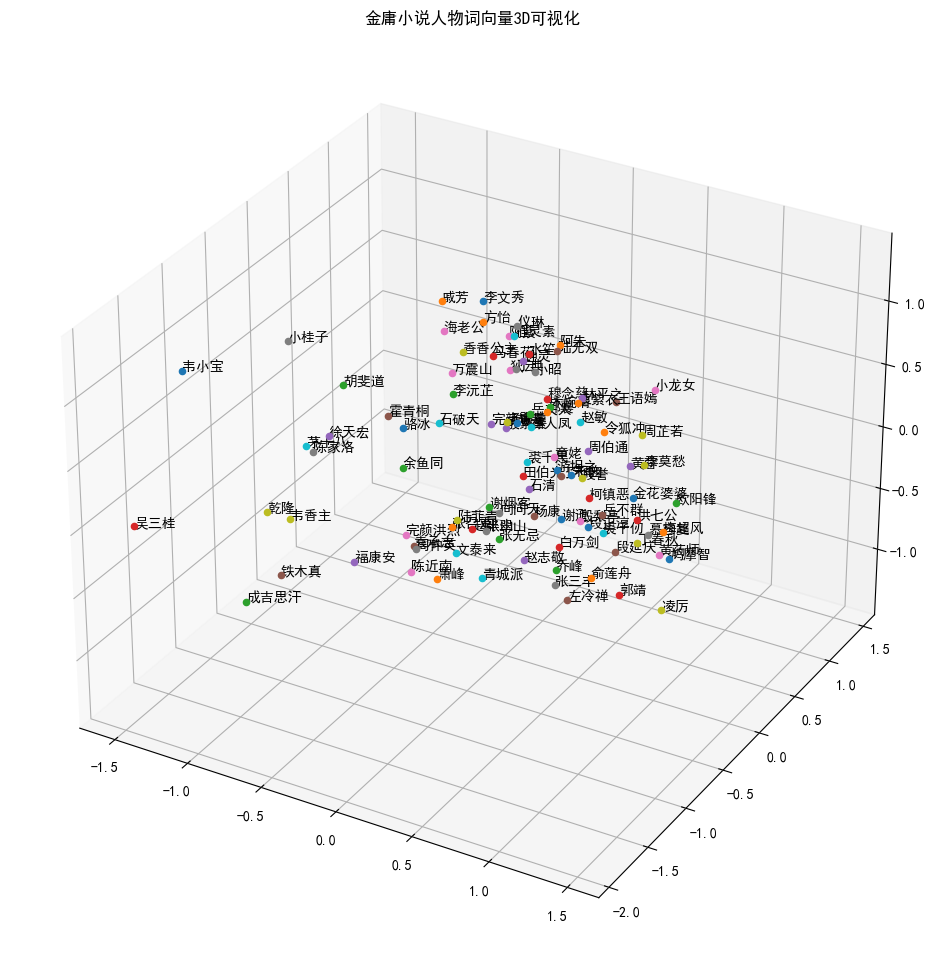

In [47]:
# 3D可视化

embeddings = []
valid_names = []
for name in character_list:
    if name in model.wv:
        embeddings.append(model.wv[name])
        valid_names.append(name)

pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings) # 用PCA降维

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
for i, name in enumerate(valid_names):
    x, y, z = reduced[i]
    ax.scatter(x, y, z)
    ax.text(x, y, z, name, fontsize=10)

ax.set_title("金庸小说人物词向量3D可视化")
plt.show()


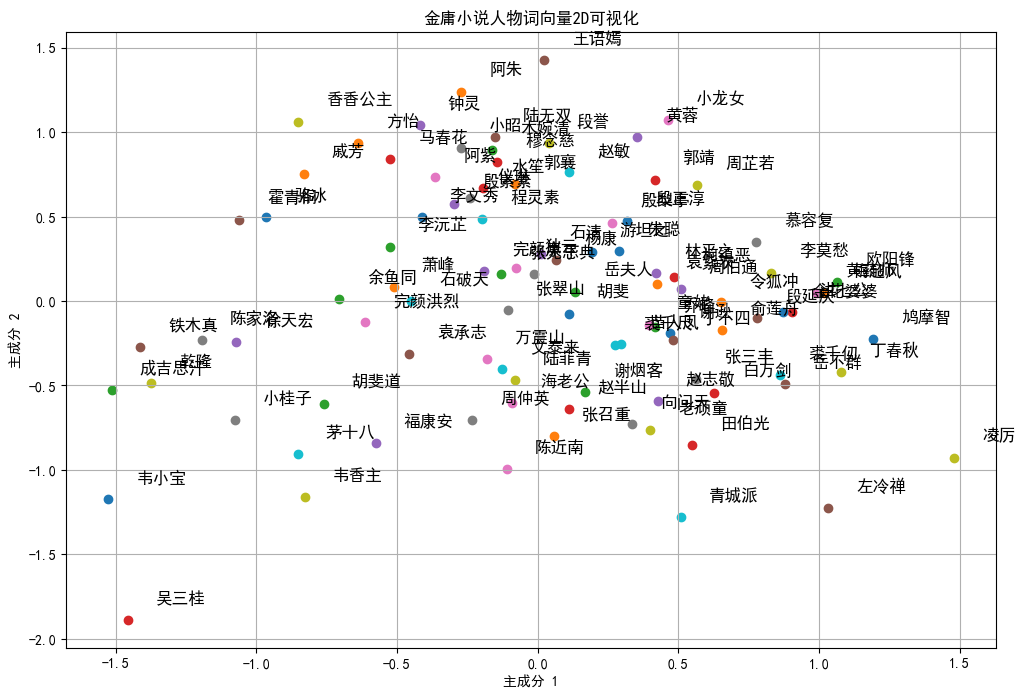

In [48]:
# 2D可视化

pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(embeddings) # PCA降维

plt.figure(figsize=(12, 8))
for i, name in enumerate(valid_names):
    x, y = reduced_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.1, y + 0.1, name, fontsize=12)

plt.title("金庸小说人物词向量2D可视化")
plt.xlabel("主成分 1")
plt.ylabel("主成分 2")
plt.grid(True)
plt.show()
